In [1]:
from data_loader import get_dataset

### Permutation Test

In [2]:
session_times = get_dataset(url = "https://raw.githubusercontent.com/gedeck/practical-statistics-for-data-scientists/refs/heads/master/data/web_page_data.csv" , 
                            file_name = "session_times")
session_times.head()

File already exists


,Page,Time
0,Page A,0.21
1,Page B,2.53
2,Page A,0.35
3,Page B,0.71
4,Page A,0.67


In [3]:
import matplotlib.pyplot as plt

Text(0.5, 0.98, '')

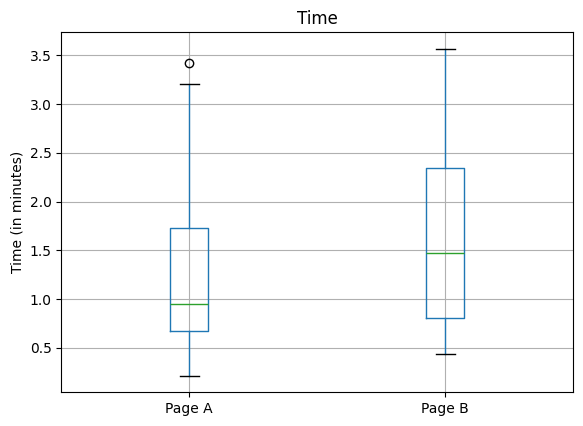

In [4]:
ax = session_times.boxplot(by = "Page" , column="Time")
ax.set_xlabel('')
ax.set_ylabel("Time (in minutes)")
plt.suptitle('')

In [5]:
mean_a = session_times[session_times["Page"] == "Page A"].Time.mean()
mean_b = session_times[session_times["Page"] == "Page B"].Time.mean()
mean_b - mean_a

np.float64(0.3566666666666669)

In [6]:
session_times["Page"].value_counts()

Page
Page A    21
Page B    15
Name: count, dtype: int64

In [7]:
import random
import pandas as pd

In [8]:
def perm_fun(x , nA , nB): 
    n = nA + nB 
    idx_B = set(random.sample(range(n) , nB))
    idx_A = set((range(n))) - idx_B
    return x.iloc[list(idx_B)].mean() - x.iloc[list(idx_A)].mean()

In [9]:
perm_diffs = [perm_fun(session_times.Time , nA= 21 , nB = 15) for _ in range(1000)]

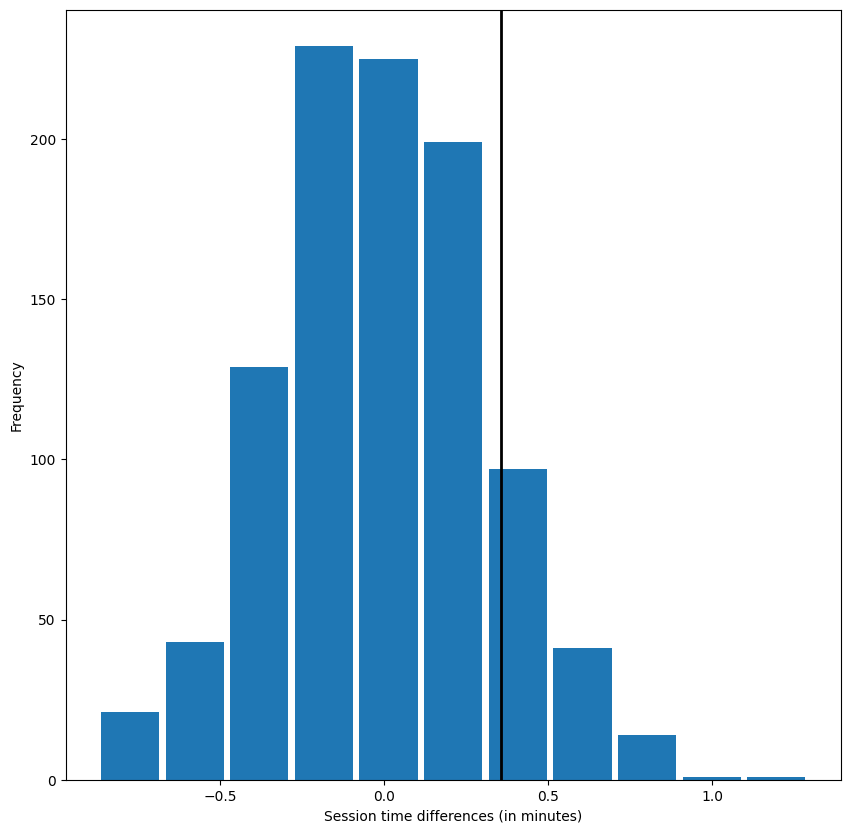

In [10]:
fig , ax = plt.subplots(figsize=( 10 , 10))
ax.hist(perm_diffs , bins = 11 , rwidth = 0.9)
ax.axvline(x = mean_b - mean_a , color = 'black' , lw = 2)
ax.set_xlabel('Session time differences (in minutes)')
ax.set_ylabel('Frequency')
plt.show()

In [11]:
import numpy as np 
np.mean(perm_diffs > (mean_b - mean_a))

np.float64(0.126)

In [12]:
obs_pct_diff = 100 *(200/23739 - 182/ 22588)
print(f"Observed differene: {obs_pct_diff:.4f}%")


Observed differene: 0.0368%


In [13]:
conversion = [0] * 45945
conversion.extend([1] * 382)
conversion = pd.Series(conversion)
conversion[:5]

0    0
1    0
2    0
3    0
4    0
dtype: int64

In [14]:
perm_diffs = [100 * perm_fun(conversion  , 23739 , 22588)
              for _ in range(1000)]
perm_diffs[:5]

[np.float64(0.06691736986579894),
 np.float64(-0.02811830501339343),
 np.float64(0.032358942637001654),
 np.float64(0.015079729022603183),
 np.float64(-0.05403712543499122)]

Text(0, 0.5, 'Frequency')

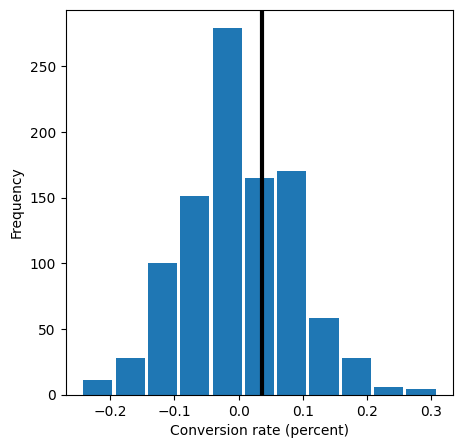

In [15]:
fig , ax = plt.subplots(figsize =(5 , 5))
ax.hist(perm_diffs , bins = 11 , rwidth = 0.9)
ax.axvline(x = obs_pct_diff , color="black" , lw = 3)
ax.set_xlabel('Conversion rate (percent)')
ax.set_ylabel('Frequency')

In [16]:
#p-value 
np.mean([diff > obs_pct_diff for diff in perm_diffs])

np.float64(0.319)

In [17]:
from scipy.stats import chi2_contingency

survivors = np.array([[200 , 23539] , [182 , 22588]])
chi2 ,p_value  , df, _ = chi2_contingency(survivors)

print(f"p-value for single sided test: {p_value/2:.4f}")

p-value for single sided test: 0.3211


###  T-test

In [18]:
import scipy.stats as stats

In [19]:
res = stats.ttest_ind(session_times[session_times.Page == 'Page A'].Time , 
                      session_times[session_times.Page == 'Page B'].Time , 
                      equal_var = False)
print(f"p-value for single sided test: {res.pvalue / 2:.4f}")

p-value for single sided test: 0.1408


In [20]:
np.random.seed(42)
num_tests = 20 
p_values = np.random.uniform(0  , 1 ,num_tests)
false_positives = np.sum(p_value < 0.05)
print(f"Number of false positives(Type I errors): {false_positives}")

Number of false positives(Type I errors): 0


### ANOVA

In [21]:
four_sessions = get_dataset(url="https://raw.githubusercontent.com/gedeck/practical-statistics-for-data-scientists/refs/heads/master/data/four_sessions.csv" , 
                            file_name= "four_sessions")
four_sessions.head()

File already exists


,Page,Time
0,Page 1,164
1,Page 2,178
2,Page 3,175
3,Page 4,155
4,Page 1,172


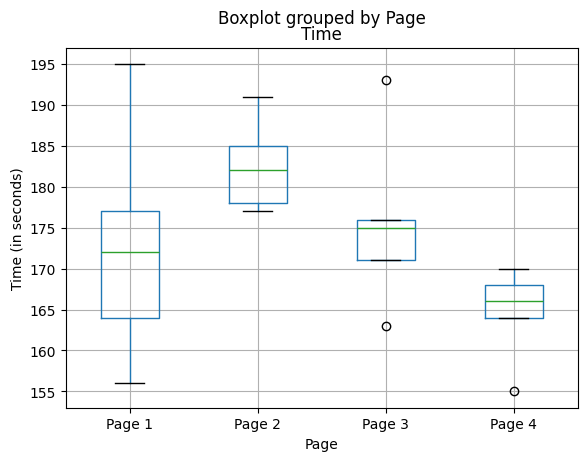

In [22]:

ax = four_sessions.boxplot( by = 'Page' , column = 'Time')
ax.set_xlabel("Page")
ax.set_ylabel("Time (in seconds)")
plt.show()

In [23]:
observed_variance = four_sessions.groupby('Page').mean().var().iloc[0]
print('Observed means: ' , four_sessions.groupby('Page').mean().values.ravel())
print('Variance: ' , observed_variance)

Observed means:  [172.8 182.6 175.6 164.6]
Variance:  55.426666666666655


In [24]:
def perm_test(df):
    df = df.copy()
    df['Time'] = np.random.permutation(df['Time'].values)
    return df.groupby('Page').mean().var().iloc[0]


In [25]:
perm_variance = [perm_test(four_sessions) for _ in range(3000)]
print("Pr(Prob)" , np.mean([var > observed_variance for var in perm_variance]))

Pr(Prob) 0.085


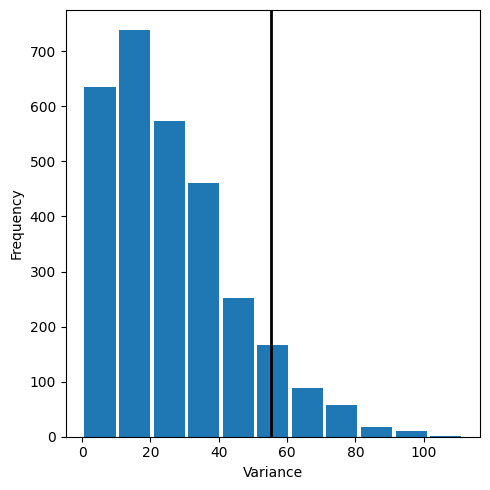

In [34]:
fig , ax = plt.subplots(figsize=(5 ,5 ))
ax.hist(perm_variance , bins = 11 , rwidth= 0.9)
ax.axvline(x = observed_variance , color = 'black' , lw = 2 ) 
ax.set_xlabel("Variance") 
ax.set_ylabel("Frequency") 

plt.tight_layout()
plt.show()

### F-statistic

In [35]:
import statsmodels.api as sm 
import statsmodels.formula.api as smf 
from statsmodels.stats import power

In [36]:
model = smf.ols('Time ~ Page' , data = four_sessions).fit()
aov_table = sm.stats.anova_lm(model)
aov_table

,df,sum_sq,mean_sq,F,PR(>F)
Page,3.0,831.4,277.133333,2.739825,0.077586
Residual,16.0,1618.4,101.150000,NaN,NaN
